# Imports & df's

In [305]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from source import config
from source import utils

df_single = pd.read_csv(config.INTERIM_DATA_DIR / 'Enkeltaksler axle load distribution.csv') 
df_boggi = pd.read_csv(config.INTERIM_DATA_DIR / 'Boggiaksler axle load distribution.csv') 
df_triple = pd.read_csv(config.INTERIM_DATA_DIR / 'Trippelaksler axle load distribution.csv') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [306]:
label_x_axis = 'Tonn'
label_y_axis = 'Prosent av den totale fordelingen'
title_multiple = 'Aksellastfordeling for samtlige konfigurasjoner (total, alle lokasjoner)'
title_multiple_n200 = f'{title_multiple}, sammenliknet med N200'
title_multiple_esal = f'{title_multiple_n200} og ekvivalensfaktor'

ax1_legend_config_base = {
    'loc': 'upper center',
    'bbox_to_anchor': (0.625, 1),
    'ncol': 1,
}
ax_1_legened_config_single = {
    'title': 'Prosent av fordelingen',
    **ax1_legend_config_base
}
ax_1_legened_config_multiple = {
    'title': 'Prosent av fordelingen\nfor hver akselkonfigurasjon',
    **ax1_legend_config_base
}
ax2_legend_config = {
    'title': 'Ekvivalensfaktor',
    'loc': 'upper center',
    'bbox_to_anchor': (0.8, 1),
    'ncol': 1
}

bar_width_n200 = 0.90
bar_width_axle = 0.2

color = {
    'enkeltaksel': 'dodgerblue',
    'boggiaksel': 'fuchsia',
    'trippelaksel': 'lime',
    'N200': 'darkorange',
    'esal': 'black'
}
opacity_n200 = 0.5

# Variables

In [307]:
tonnage_categories = df_single.columns[1:]
df_single_total = df_single[df_single['Sted'] == 'Total'][tonnage_categories].values.flatten()
df_boggi_total = df_boggi[df_boggi['Sted'] == 'Total'][tonnage_categories].values.flatten()
df_triple_total = df_triple[df_triple['Sted'] == 'Total'][tonnage_categories].values.flatten()

n200_categories = list(config.Axle_load_distribution_10_ton_road_percentage_N200.keys())
n200_values = list(config.Axle_load_distribution_10_ton_road_percentage_N200.values())

axle_group_k_values = {
    'enkeltaksel': 1,
    'boggiaksel': (10/18)**4,
    'trippelaksel': (10/24)**4
}

esal = lambda w, axle_group: ((w / 10)**4) * axle_group_k_values[axle_group]
esal_x = np.linspace(0, 30, 1000)

delta_total_values = 10e-3

# Plotting code

In [308]:
def plot_individual_bars(df, axle_type, mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bar_width = 0.4  # Width of each bar

    if axle_type == 'enkeltaksel':
        total_values = df_single_total
    elif axle_type == 'boggiaksel':
        total_values = df_boggi_total
    elif axle_type == 'trippelaksel':
        total_values = df_triple_total
    else:
        raise ValueError("Invalid axle_type.")

    total_values, threshold_index = utils.trim_tonnage_x_axis(total_values=total_values, delta=delta_total_values)
    tonnage_categories_list = list(tonnage_categories)[:threshold_index]
    x = np.arange(len(tonnage_categories[:threshold_index]))
    ax1.bar(x, total_values, width=bar_width, label='Total', color=color[axle_type], zorder=2)
    
    if mode == 'N200' or mode == 'esal':
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        # ax1.bar(np.array(n200_x_positions) + bar_width, n200_values, width=bar_width, label='N200', color=color['N200'])
        ax1.bar(n200_x_positions, n200_values, width=bar_width_n200, label='N200', color=color['N200'], zorder=1, alpha=opacity_n200)    

    if mode == 'esal':
        ax2 = ax1.twinx()
        cur_esal_x = esal_x[esal_x < threshold_index]
        esal_y = esal(cur_esal_x, axle_type)
        ax2.plot(cur_esal_x, esal_y, label='Ekvivalensfaktor', color=color['esal'], linewidth=2)
        ax2.set_ylabel('Ekvivalensfaktor')
        ax2.set_ylim(bottom=0)
    
    ax1.set_title(
        f'Aksellastfordeling for {axle_type} (Total, alle lokasjoner)' 
        + (', sammenliknet med N200' if mode == 'N200' or mode == 'esal' else '')
        + (' og ekvivalensfaktor' if mode == 'esal' else '')
    )
    ax1.set_xlabel(label_x_axis)
    ax1.set_ylabel(label_y_axis)
    ax1.set_xticks(x)
    ax1.set_xticklabels(tonnage_categories[:threshold_index], rotation=90)
    
    ax1.legend(**ax_1_legened_config_single)

    if mode == 'esal':
        ax2.legend(**ax2_legend_config)
    
    plt.tight_layout()
    plt.show()

def plot_combined_value_bars(mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Convert tonnage_categories to a list
    tonnage_categories_list = list(tonnage_categories)
    
    # Define x-axis positions
    indices = np.arange(len(tonnage_categories_list))
    
    # Plot N200 bars (fat bars in the background)
    if mode == 'N200' or mode == 'esal':
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        ax1.bar(n200_x_positions, n200_values, width=bar_width_n200, label='N200', color=color['N200'], zorder=1, alpha=opacity_n200)
    
    # Plot axle type bars (thinner bars in the foreground)
    ax1.bar(indices - bar_width_axle, df_single_total, width=bar_width_axle, label='enkeltaksel', color=color['enkeltaksel'], zorder=2)
    ax1.bar(indices, df_boggi_total, width=bar_width_axle, label='boggiaksel', color=color['boggiaksel'], zorder=2)
    ax1.bar(indices + bar_width_axle, df_triple_total, width=bar_width_axle, label='trippelaksel', color=color['trippelaksel'], zorder=2)
    
    # Add ESAL line if mode is 'esal'
    if mode == 'esal':
        ax2 = ax1.twinx()
        cur_esal_x = esal_x[esal_x < len(tonnage_categories_list)]
        esal_y = esal(cur_esal_x, 'enkeltaksel')
        ax2.plot(cur_esal_x, esal_y, label='Ekvivalensfaktor', color=color['esal'], linewidth=2, zorder=3)
        ax2.set_ylabel('Ekvivalensfaktor')
        ax2.legend(**ax2_legend_config)
        ax2.set_ylim(bottom=0)
    
    # Set chart title and labels
    ax1.set_title(title_multiple if mode == 'default' else title_multiple_n200 if mode == 'N200' else title_multiple_esal)
    ax1.set_xlabel(label_x_axis)
    ax1.set_ylabel(label_y_axis)
    ax1.set_xticks(indices)
    ax1.set_xticklabels(tonnage_categories_list, rotation=90)
    
    # Add legend for the bars
    ax1.legend(**ax_1_legened_config_multiple)
    
    plt.tight_layout()
    plt.show()

def plot_line_chart(mode='default'):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Convert tonnage_categories to a list
    tonnage_categories_list = list(tonnage_categories)

    # Plot lines for each axle type
    ax1.plot(tonnage_categories_list, df_single_total, label='enkeltaksel', marker='o', color=color['enkeltaksel'])
    ax1.plot(tonnage_categories_list, df_boggi_total, label='boggiaksel', marker='s', color=color['boggiaksel'])
    ax1.plot(tonnage_categories_list, df_triple_total, label='trippelaksel', marker='^', color=color['trippelaksel'])

    # Plot N200 bars (fat bars in the background)
    if mode == 'N200' or mode == 'esal':
        n200_x_positions = [tonnage_categories_list.index(cat) for cat in n200_categories if cat in tonnage_categories_list]
        ax1.bar(n200_x_positions, n200_values, width=bar_width_n200, label='N200', color=color['N200'], zorder=1, alpha=opacity_n200)

    # Add ESAL line if mode is 'esal'
    if mode == 'esal':
        ax2 = ax1.twinx()
        cur_esal_x = esal_x[esal_x < len(tonnage_categories_list)]
        esal_y = esal(cur_esal_x, 'enkeltaksel')
        ax2.plot(cur_esal_x, esal_y, label='Ekvivalensfaktor', color=color['esal'], linewidth=2, zorder=3)
        ax2.set_ylabel('Ekvivalensfaktor')
        ax2.legend(**ax2_legend_config)
        ax2.set_ylim(bottom=0)

    # Set chart title and labels'
    ax1.set_title(title_multiple if mode == 'default' else title_multiple_n200 if mode == 'N200' else title_multiple_esal)
    ax1.set_xlabel(label_x_axis)
    ax1.set_ylabel(label_y_axis)
    ax1.set_xticks(range(len(tonnage_categories_list)))
    ax1.set_xticklabels(tonnage_categories_list, rotation=90)

    # Add legend for the lines
    ax1.legend(**ax_1_legened_config_multiple)

    plt.tight_layout()
    plt.show()

# Plotting

## Solely axle loads

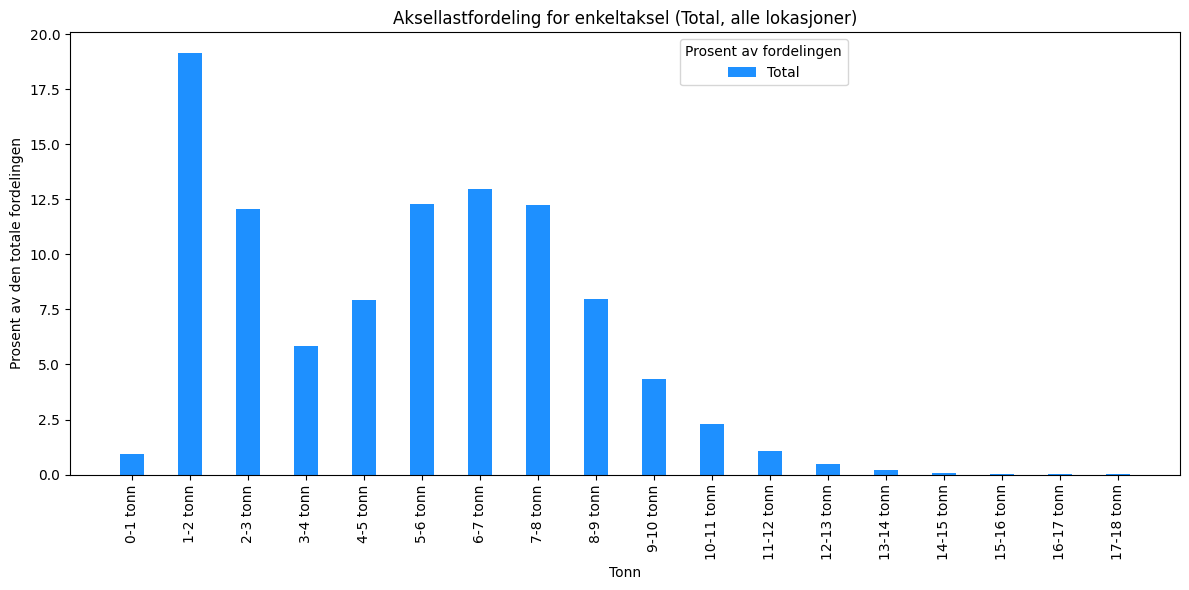

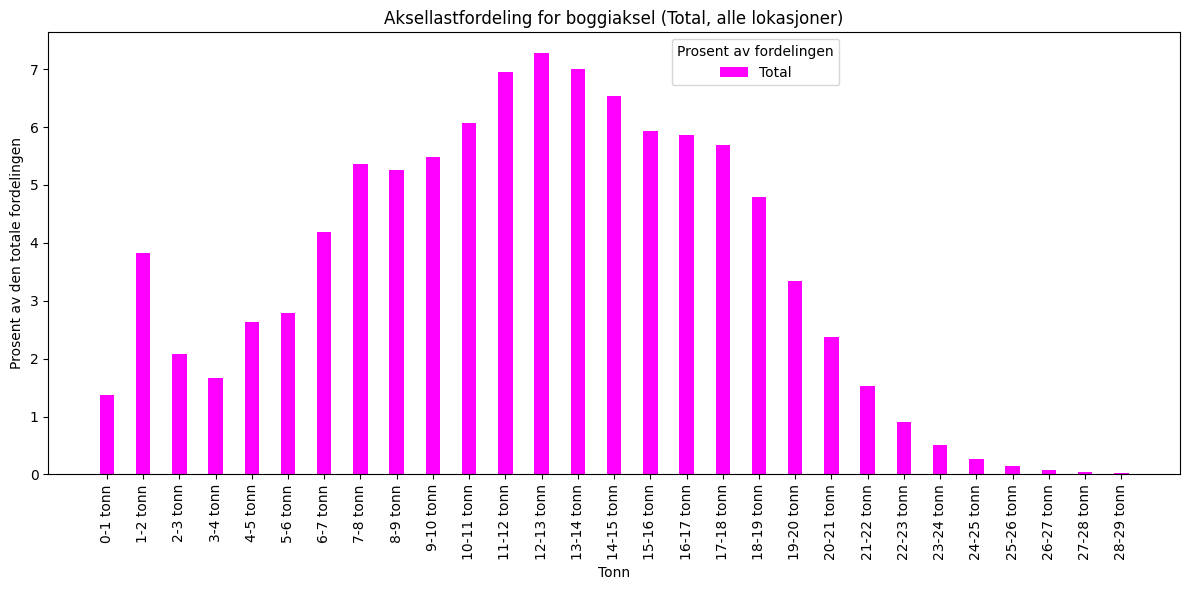

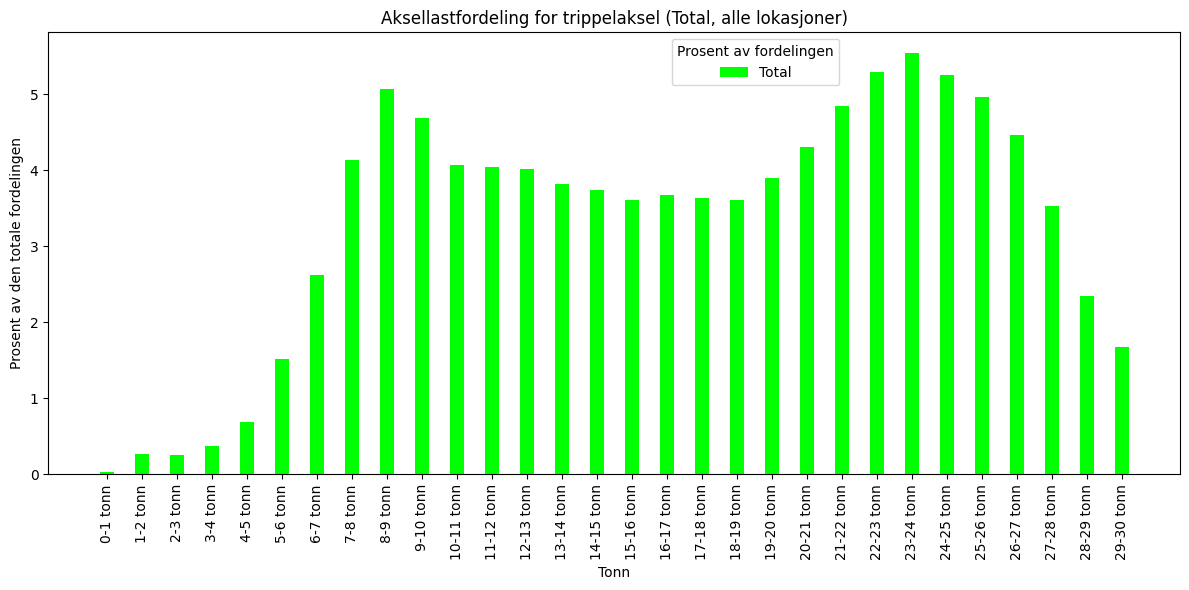

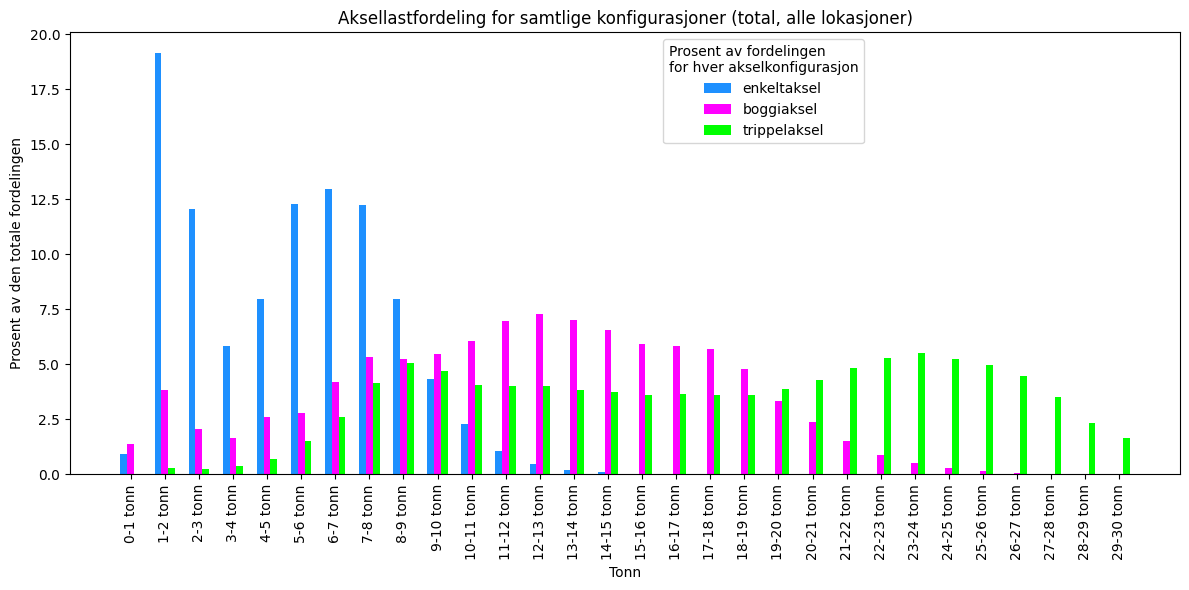

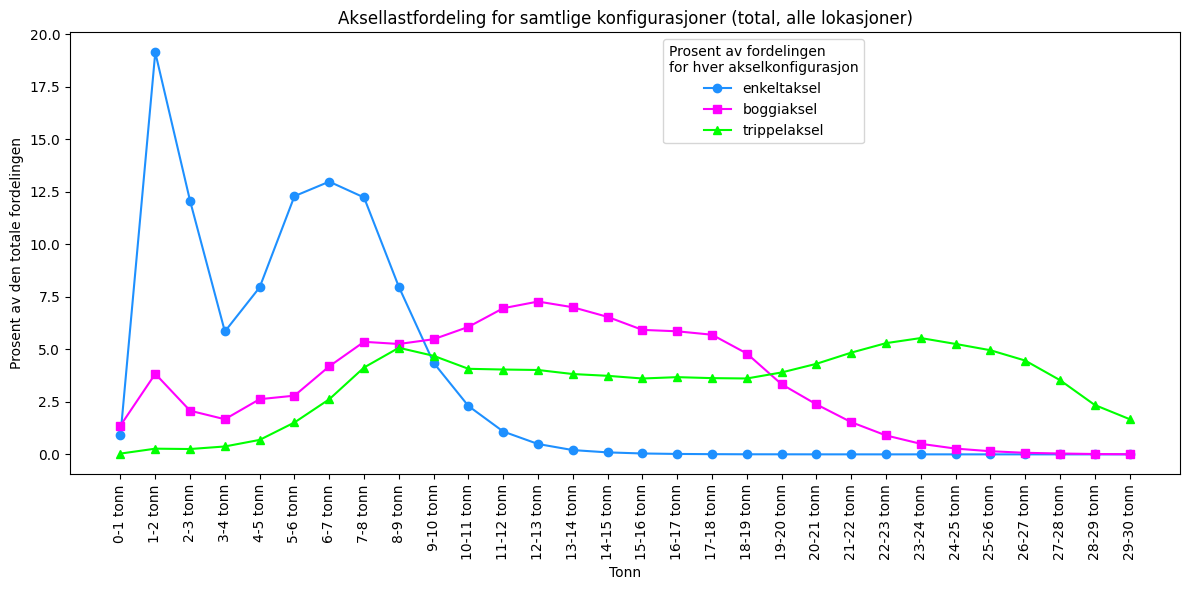

In [309]:
plot_individual_bars(df_single, 'enkeltaksel', mode='default')
plot_individual_bars(df_boggi, 'boggiaksel', mode='default')
plot_individual_bars(df_triple, 'trippelaksel', mode='default')
plot_combined_value_bars(mode='default')
plot_line_chart(mode='default')

## Axle loads with N200

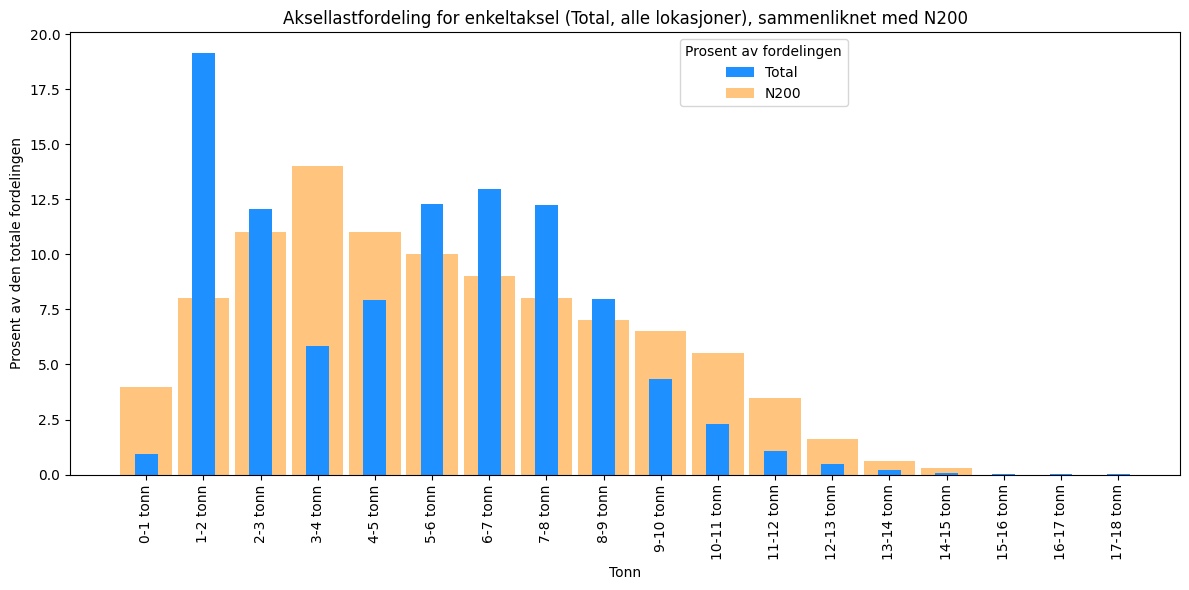

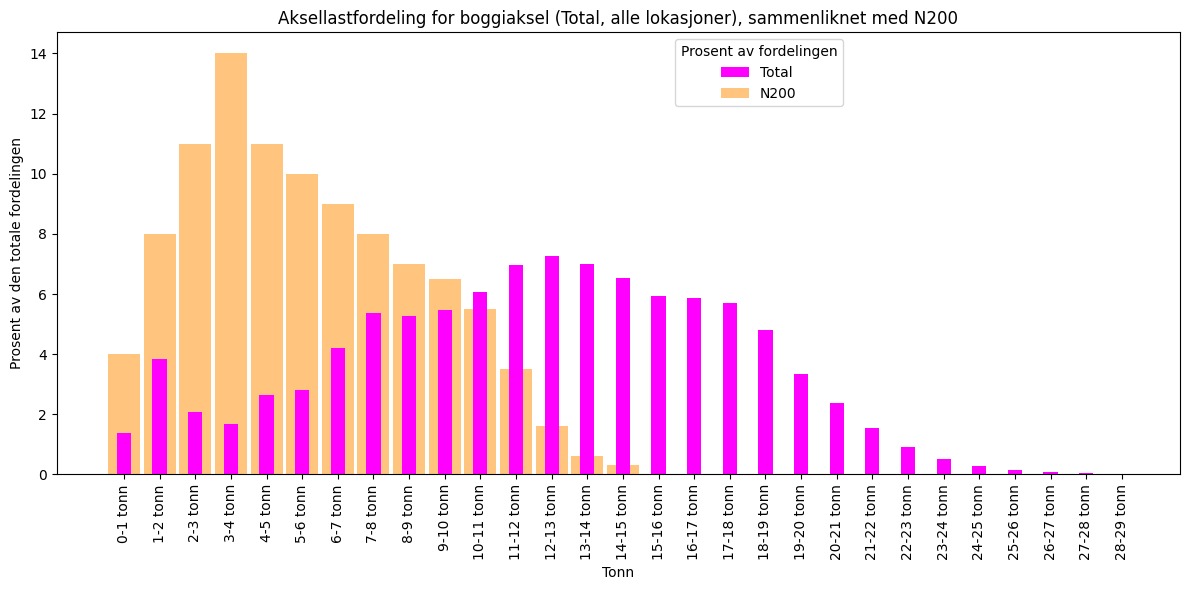

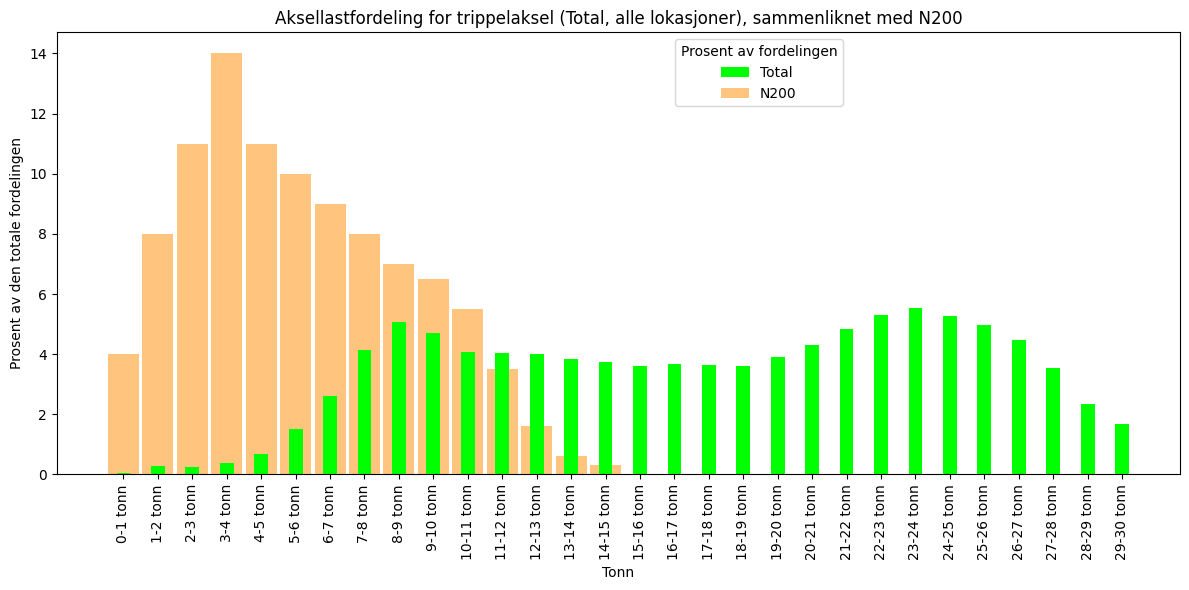

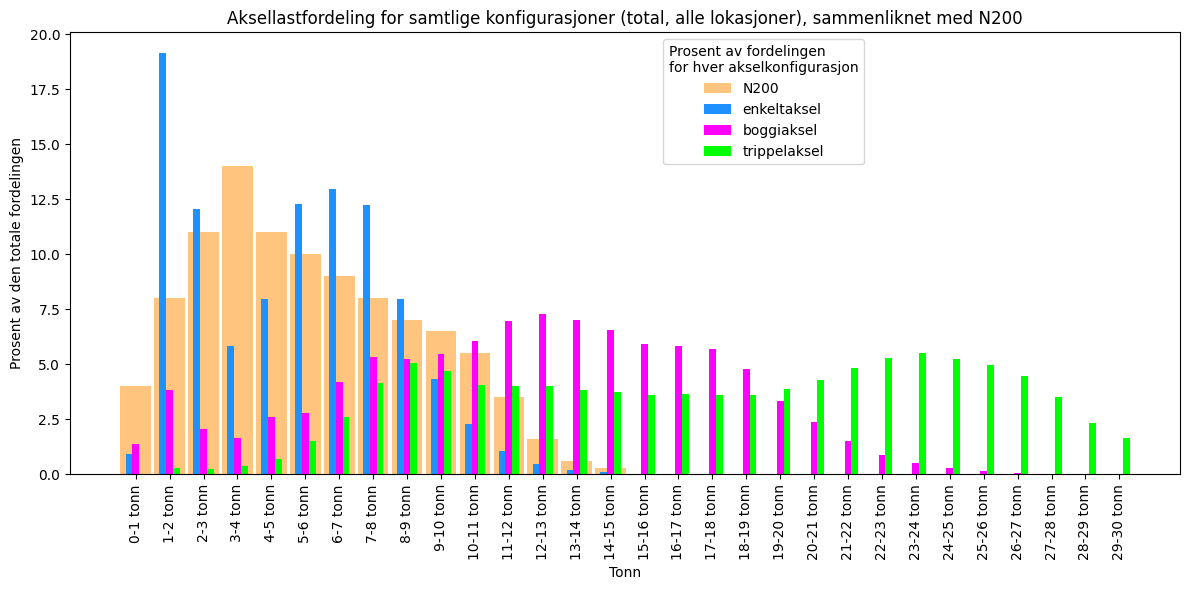

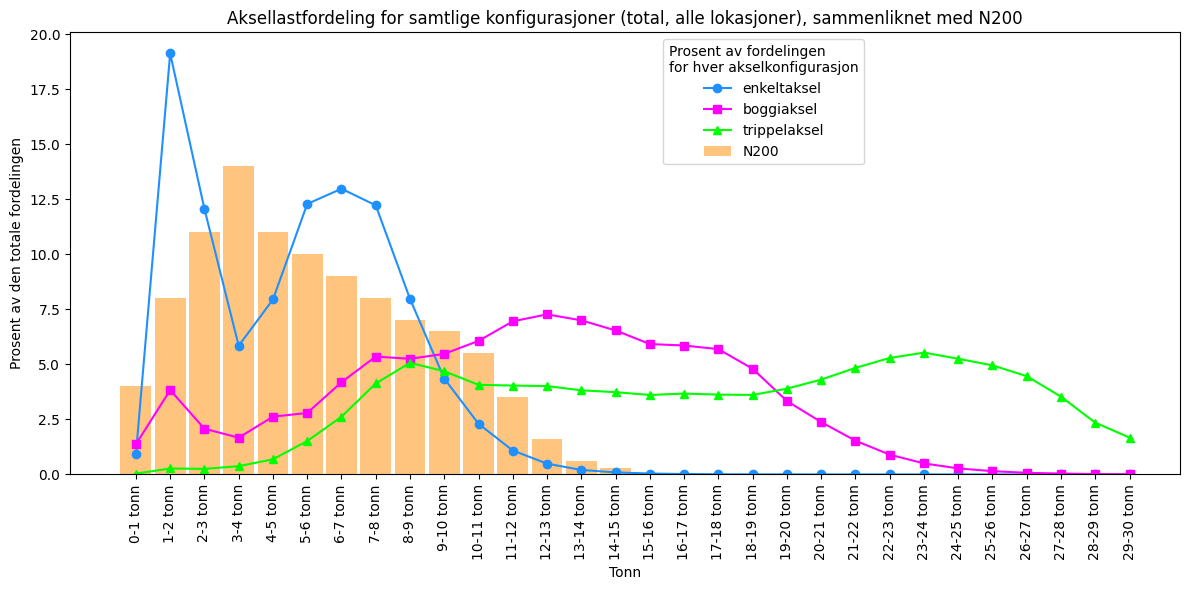

In [310]:
plot_individual_bars(df_single, 'enkeltaksel', mode='N200')
plot_individual_bars(df_boggi, 'boggiaksel', mode='N200')
plot_individual_bars(df_triple, 'trippelaksel', mode='N200')
plot_combined_value_bars(mode='N200')
plot_line_chart(mode='N200')

## Axle loads with N200 and ESAL

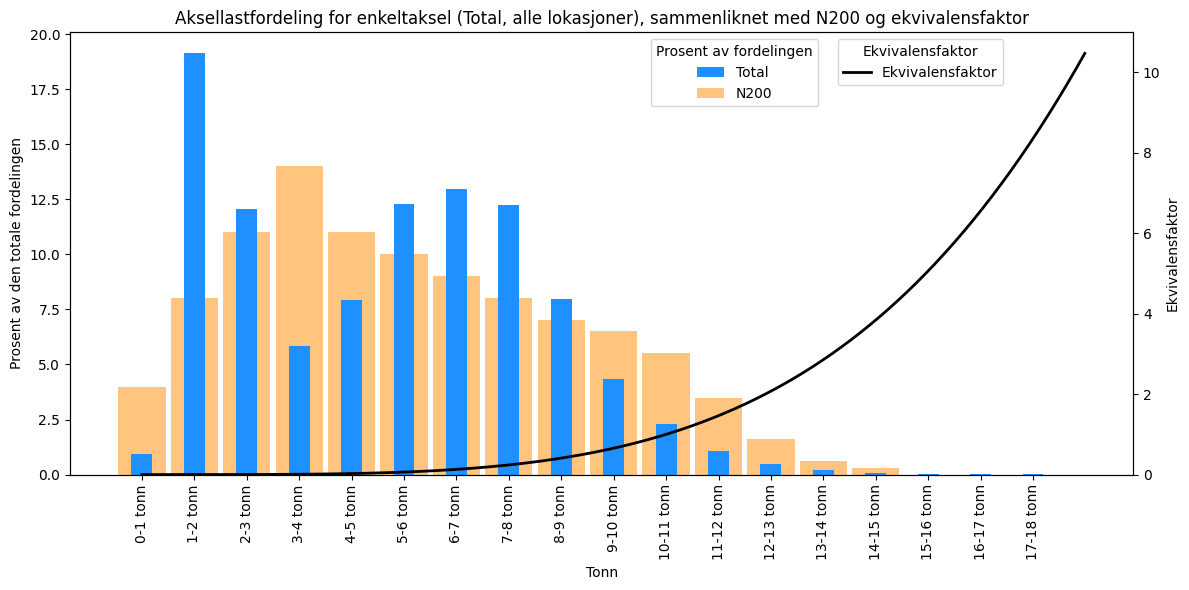

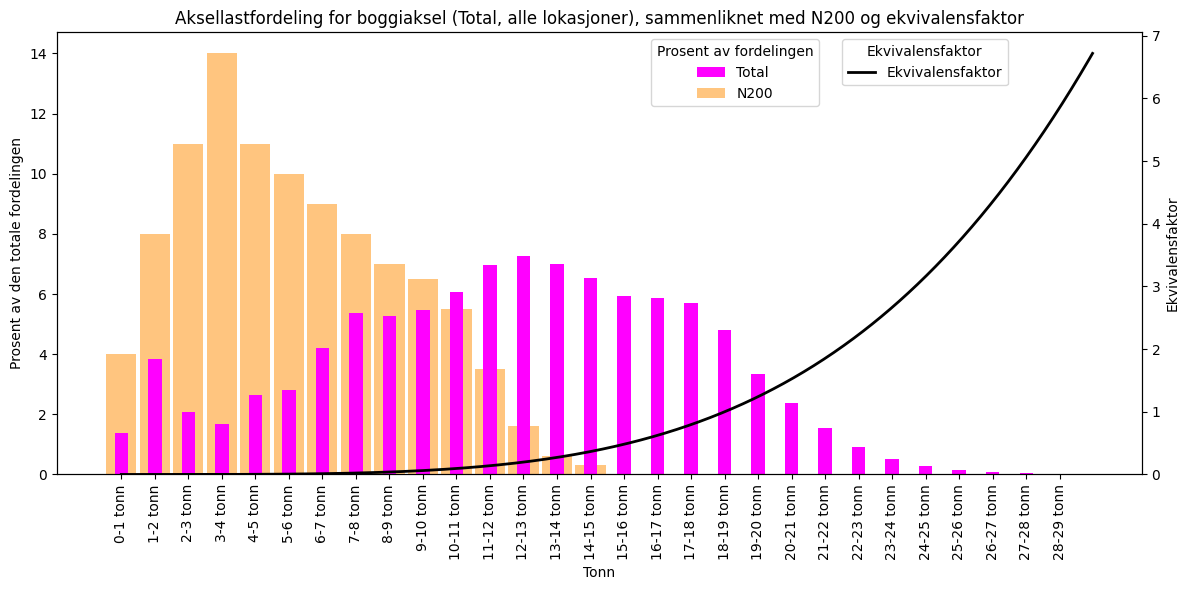

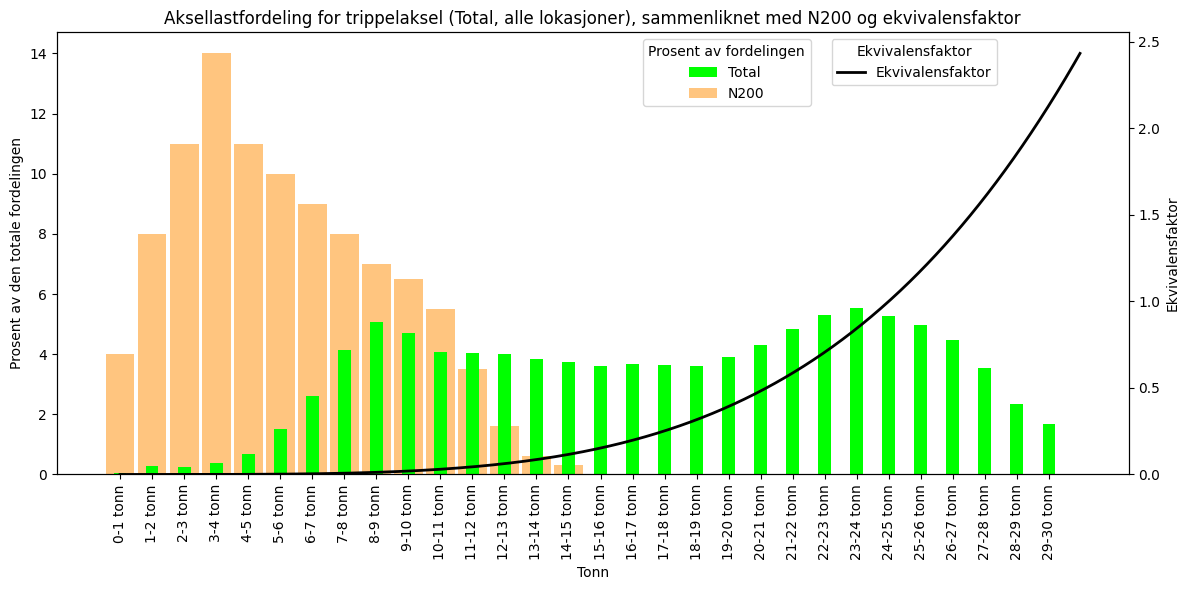

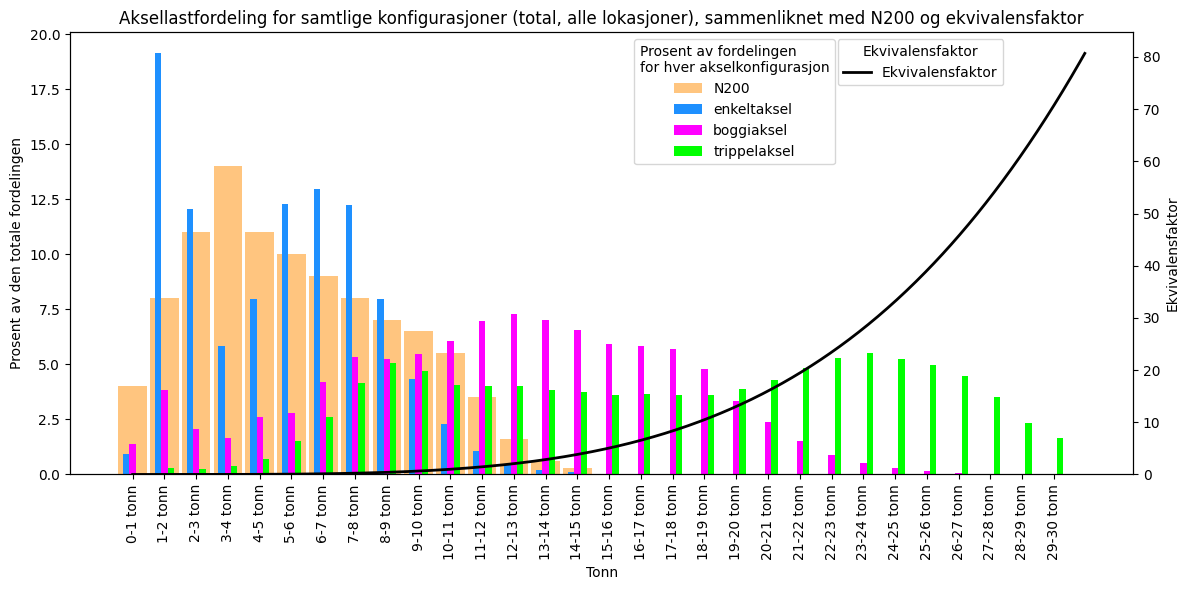

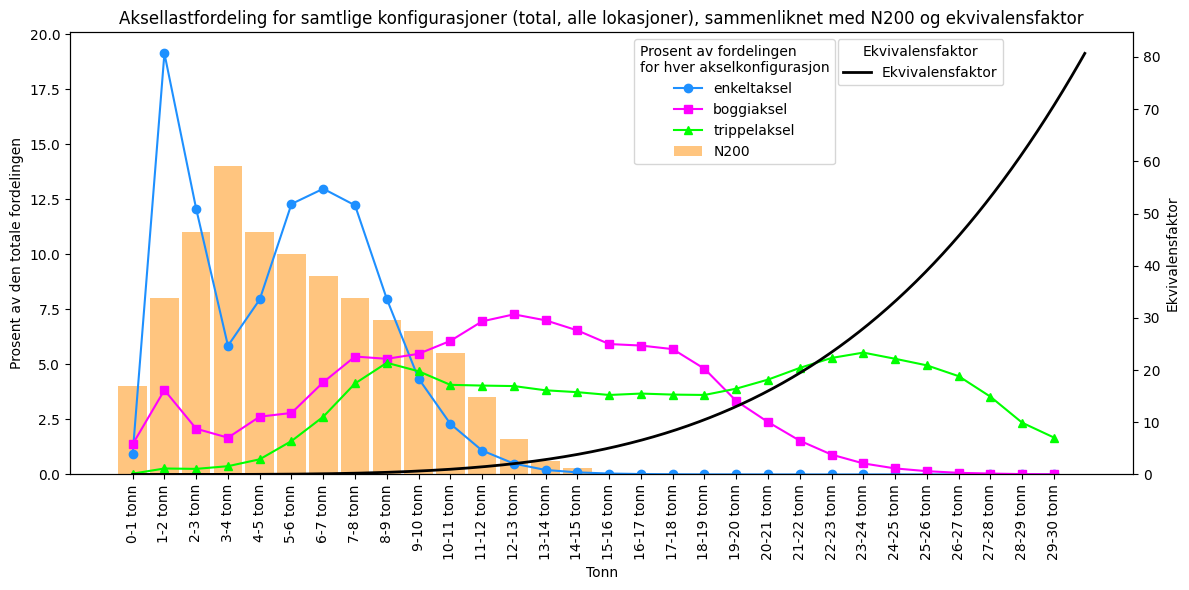

In [311]:
plot_individual_bars(df_single, 'enkeltaksel', mode='esal')
plot_individual_bars(df_boggi, 'boggiaksel', mode='esal')
plot_individual_bars(df_triple, 'trippelaksel', mode='esal')
plot_combined_value_bars(mode='esal')
plot_line_chart(mode='esal')